# ECG analysis from PTB-XL dataset
## Idoven Data Scientist Task
---
#### Carla Guillén Pingarrón
---

In this notebook, I will show my mental process for analysing ECG data, particularlly the [PTB-XL dataset].

This dataset contains waveform ECG files in WaveForm DataBase (WFDB) format, so the first step is to understand how this data is encoded: how to read it and what are its contents. Conveniently, there is a specific [wfdb-python] package for working with this format.

The PTB-XL dataset has two directories containing waveform ECG files: one at the original 500 Hz frequency and another one downsampled to 100 Hz frequency. All the metadata is inside the `ptbxl_database.csv`, which contains all the information about each ECG, with a unique `ecg_id` as well as a `patient_id` that can appear more than once for patients that have undergone several ECGs. The dataset also points to the file containing the corresponding waveform data for each `ecg_id`, in columns `filename_lr` (100 Hz) and `filename_hr` (500 Hz) 

With all of this in mind, I wrote a [`ptb_xl.py`](data/ptb_xl.py) source file that contains:
* An Enum `SamplingRates` for the two avalaible resolutions: `LOW` for 100 Hz and `HIGH` for 500 Hz. 
* A `Dataset` class that:
    * Reads PTB-XL metadata from `ptbxl_database.csv` into attribute `db` as a `pandas.Dataframe`.
    * Loads the waveform file for each ECG into an extra column `db.record` using the specified sample rate (`LOW` by default). The waveform file is read as a `wfdb.Record` object, which contains the physical signal + all wfdb descriptors.
    * Reads ECG annotations from `scp_statements.csv` into attribute `annotations` as a `pandas.Dataframe`.


[PTB-XL dataset]: https://physionet.org/content/ptb-xl/1.0.3/
[wfdb-python]: https://physionet.org/content/wfdb-python/4.0.0/
[WFDB documentaton]: https://wfdb.readthedocs.io/en/latest/

In [1]:
from data.ptb_xl import SamplingRates, Dataset

I use `LOW` sampling rate (100 Hz) to speed up the processing. All steps can be rerun later with `HIGH` sampling rate (500 Hz) for extra precision.

In [2]:
sampling_rate = SamplingRates.LOW # 100 Hz
# sampling_rate = SamplingRates.HIGH # 500 Hz

# If not specified when invoking the constructor, sampling_rate will be 100 Hz 
# by defult
dataset = Dataset(sampling_rate=sampling_rate)

## 1. General analysis of the dataset

#### 1.1 Waveform data
In `dataset.db`, the last column (`record`) contains the ECG information at the corresponding `sampling_rate` as a `wfdb.Record` object. All the attributes of a `wfdb.Record` object can be found in the [documentation]. Here I quickly invoke the keys of its internal `__dict__` for a first glance: 


[documentation]:https://wfdb.readthedocs.io/en/latest/wfdb.html

In [3]:
dataset.db.record[1].__dict__.keys()

dict_keys(['record_name', 'n_sig', 'fs', 'counter_freq', 'base_counter', 'sig_len', 'base_time', 'base_date', 'comments', 'sig_name', 'p_signal', 'd_signal', 'e_p_signal', 'e_d_signal', 'file_name', 'fmt', 'samps_per_frame', 'skew', 'byte_offset', 'adc_gain', 'baseline', 'units', 'adc_res', 'adc_zero', 'init_value', 'checksum', 'block_size'])

As it can be seen, this object contains the physical signal (`record.p_signal`) as well as all the information contained in `wfdb.Header`. Another relevant field is  `sig_name` that contains the name of the ECG-leads in the same order as the signal (see section 3 for more details about leads).

In [4]:
print(f'p_signal: {dataset.db.record[1].p_signal}')
print(f'sig_name: {dataset.db.record[1].sig_name}')

p_signal: [[-0.119 -0.055  0.064 ... -0.026 -0.039 -0.079]
 [-0.116 -0.051  0.065 ... -0.031 -0.034 -0.074]
 [-0.12  -0.044  0.076 ... -0.028 -0.029 -0.069]
 ...
 [ 0.069  0.    -0.069 ...  0.024 -0.041 -0.058]
 [ 0.086  0.004 -0.081 ...  0.242 -0.046 -0.098]
 [ 0.022 -0.031 -0.054 ...  0.143 -0.035 -0.12 ]]
sig_name: ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']


For each `ecg_id`, `p_signal` contains 1000 measurements (100 Hz x 10 s) for each of the 12 leads:

In [5]:
print(f'Shape of each Physical signal entrance {dataset.db.record[1].p_signal.shape}')

Shape of each Physical signal entrance (1000, 12)


#### 1.2 ECG metadata

Now let's look at the structure of the ECG metadata loaded from `ptbxl_database.csv`. 

In [6]:
print(f'Database shape: {dataset.db.shape}')
print(f'Number of patients: {len(dataset.db.patient_id.unique())}')

Database shape: (21801, 44)
Number of patients: 18869


The database has 21801 rows (recorded ECGs) distributed among a total of 18869 patients as throughly described in the [PTB-XL dataset] notes. All the columns in `database.db` (except for `record`, as described before) came from the ECG metadata provided in `ptbxl_database.csv`. By checking the type of each column we can have a general idea of what they contain.

[PTB-XL dataset]: https://physionet.org/content/ptb-xl/1.0.3/


In [7]:
print(f'Database columns: {dict(dataset.db.dtypes)}\n')

Database columns: {'patient_id': dtype('float64'), 'age': dtype('float64'), 'sex': dtype('int64'), 'height': dtype('float64'), 'weight': dtype('float64'), 'nurse': dtype('float64'), 'site': dtype('float64'), 'device': dtype('O'), 'recording_date': dtype('O'), 'report': dtype('O'), 'scp_codes': dtype('O'), 'heart_axis': dtype('O'), 'infarction_stadium1': dtype('O'), 'infarction_stadium2': dtype('O'), 'validated_by': dtype('float64'), 'second_opinion': dtype('bool'), 'initial_autogenerated_report': dtype('bool'), 'validated_by_human': dtype('bool'), 'baseline_drift': dtype('O'), 'static_noise': dtype('O'), 'burst_noise': dtype('O'), 'electrodes_problems': dtype('O'), 'extra_beats': dtype('O'), 'pacemaker': dtype('O'), 'strat_fold': dtype('int64'), 'filename_lr': dtype('O'), 'filename_hr': dtype('O'), 'r_peaks': dtype('O'), 'RS-LVH': dtype('bool'), 'S12-LVH': dtype('bool'), 'R56-LVH': dtype('bool'), 'QRS-LVH': dtype('bool'), 'LI-LVH': dtype('bool'), 'SLI-LVH': dtype('bool'), 'QRS-CLBB': d

Here is a table excerpt from the [PTB-XL publication] describing each of the columns:

[PTB-XL publication]: https://www.nature.com/articles/s41597-020-0495-6

<table class="data last-table">
  <thead class="c-article-table-head">
    <tr>
      <th class="u-text-left ">
        Section
      </th>
      <th class="u-text-left ">
        Variable
      </th>
      <th class="u-text-left ">
        Data Type
      </th>
      <th class="u-text-left ">
        Description
      </th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td rowspan="4" class="u-text-left ">
        Identifiers
      </td>
      <td class="u-text-left ">
        ecg_id
      </td>
      <td class="u-text-left ">
        integer
      </td>
      <td class="u-text-left ">
        unique ECG identifier
      </td>
    </tr>
    <tr>
      <td class="u-text-left ">
        patient_id
      </td>
      <td class="u-text-left ">
        integer
      </td>
      <td class="u-text-left ">
        unique patient identifier
      </td>
    </tr>
    <tr>
      <td class="u-text-left ">
        filename_lr
      </td>
      <td class="u-text-left ">
        string
      </td>
      <td class="u-text-left ">
        path to waveform data (100 Hz)
      </td>
    </tr>
    <tr>
      <td class="u-text-left ">
        filename_hr
      </td>
      <td class="u-text-left ">
        string
      </td>
      <td class="u-text-left ">
        path to waveform data (500 Hz)
      </td>
    </tr>
    <tr>
      <td rowspan="8" class="u-text-left ">
        General Metadata
      </td>
      <td class="u-text-left ">
        age
      </td>
      <td class="u-text-left ">
        integer
      </td>
      <td class="u-text-left ">
        age at recording in years (see Fig. <a data-track="click" data-track-label="link"
          data-track-action="figure anchor" href="https://www.nature.com/articles/s41597-020-0495-6#Fig3">3</a> left)
      </td>
    </tr>
    <tr>
      <td class="u-text-left ">
        sex
      </td>
      <td class="u-text-left ">
        categorical
      </td>
      <td class="u-text-left ">
        sex (male 0, female 1)
      </td>
    </tr>
    <tr>
      <td class="u-text-left ">
        height
      </td>
      <td class="u-text-left ">
        integer
      </td>
      <td class="u-text-left ">
        height in centimeters (see Fig. <a data-track="click" data-track-label="link" data-track-action="figure anchor"
          href="https://www.nature.com/articles/s41597-020-0495-6#Fig3">3</a> right)
      </td>
    </tr>
    <tr>
      <td class="u-text-left ">
        weight
      </td>
      <td class="u-text-left ">
        integer
      </td>
      <td class="u-text-left ">
        weight in kilograms (see Fig. <a data-track="click" data-track-label="link" data-track-action="figure anchor"
          href="https://www.nature.com/articles/s41597-020-0495-6#Fig3">3</a> middle)
      </td>
    </tr>
    <tr>
      <td class="u-text-left ">
        nurse
      </td>
      <td class="u-text-left ">
        categorical
      </td>
      <td class="u-text-left ">
        involved nurse (pseudonymized)
      </td>
    </tr>
    <tr>
      <td class="u-text-left ">
        site
      </td>
      <td class="u-text-left ">
        categorical
      </td>
      <td class="u-text-left ">
        recording site (pseudonymized)
      </td>
    </tr>
    <tr>
      <td class="u-text-left ">
        device
      </td>
      <td class="u-text-left ">
        categorical
      </td>
      <td class="u-text-left ">
        recording device
      </td>
    </tr>
    <tr>
      <td class="u-text-left ">
        recording_date
      </td>
      <td class="u-text-left ">
        datetime
      </td>
      <td class="u-text-left ">
        ECG recording date and time
      </td>
    </tr>
    <tr>
      <td rowspan="9" class="u-text-left ">
        ECG Statements
      </td>
      <td class="u-text-left ">
        report
      </td>
      <td class="u-text-left ">
        string
      </td>
      <td class="u-text-left ">
        ECG report from diagnosing cardiologist
      </td>
    </tr>
    <tr>
      <td class="u-text-left ">
        scp_codes
      </td>
      <td class="u-text-left ">
        dictionary
      </td>
      <td class="u-text-left ">
        SCP ECG statements (see Tables <a data-track="click" data-track-label="link" data-track-action="table anchor"
          href="https://www.nature.com/articles/s41597-020-0495-6#Tab6">6</a>, <a data-track="click" data-track-label="link"
          data-track-action="table anchor" href="https://www.nature.com/articles/s41597-020-0495-6#Tab7">7</a> and <a data-track="click"
          data-track-label="link" data-track-action="table anchor" href="https://www.nature.com/articles/s41597-020-0495-6#Tab8">8</a>)
      </td>
    </tr>
    <tr>
      <td class="u-text-left ">
        heart_axis
      </td>
      <td class="u-text-left ">
        categorical
      </td>
      <td class="u-text-left ">
        heart’s electrical axis (see Table <a data-track="click" data-track-label="link"
          data-track-action="table anchor" href="https://www.nature.com/articles/s41597-020-0495-6#Tab10">10</a>)
      </td>
    </tr>
    <tr>
      <td class="u-text-left ">
        infarction_stadium1
      </td>
      <td class="u-text-left ">
        categorical
      </td>
      <td class="u-text-left ">
        infarction stadium (see Table <a data-track="click" data-track-label="link" data-track-action="table anchor"
          href="https://www.nature.com/articles/s41597-020-0495-6#Tab11">11</a>)
      </td>
    </tr>
    <tr>
      <td class="u-text-left ">
        infarction_stadium2
      </td>
      <td class="u-text-left ">
        categorical
      </td>
      <td class="u-text-left ">
        second infarction stadium (see Table <a data-track="click" data-track-label="link"
          data-track-action="table anchor" href="https://www.nature.com/articles/s41597-020-0495-6#Tab11">11</a>)
      </td>
    </tr>
    <tr>
      <td class="u-text-left ">
        validated_by
      </td>
      <td class="u-text-left ">
        categorical
      </td>
      <td class="u-text-left ">
        validating cardiologist (pseudonymized)
      </td>
    </tr>
    <tr>
      <td class="u-text-left ">
        second_opinion
      </td>
      <td class="u-text-left ">
        boolean
      </td>
      <td class="u-text-left ">
        flag for second (deviating) opinion
      </td>
    </tr>
    <tr>
      <td class="u-text-left ">
        initial_autogenerated_report
      </td>
      <td class="u-text-left ">
        boolean
      </td>
      <td class="u-text-left ">
        initial autogenerated report by ECG device
      </td>
    </tr>
    <tr>
      <td class="u-text-left ">
        validated_by_human
      </td>
      <td class="u-text-left ">
        boolean
      </td>
      <td class="u-text-left ">
        validated by human
      </td>
    </tr>
    <tr>
      <td rowspan="6" class="u-text-left ">
        Signal Metadata
      </td>
      <td class="u-text-left ">
        baseline_drift
      </td>
      <td class="u-text-left ">
        string
      </td>
      <td class="u-text-left ">
        baseline drift or jump present
      </td>
    </tr>
    <tr>
      <td class="u-text-left ">
        static_noise
      </td>
      <td class="u-text-left ">
        string
      </td>
      <td class="u-text-left ">
        electric hum/static noise present
      </td>
    </tr>
    <tr>
      <td class="u-text-left ">
        burst_noise
      </td>
      <td class="u-text-left ">
        string
      </td>
      <td class="u-text-left ">
        burst noise
      </td>
    </tr>
    <tr>
      <td class="u-text-left ">
        electrodes_problems
      </td>
      <td class="u-text-left ">
        string
      </td>
      <td class="u-text-left ">
        electrodes problems
      </td>
    </tr>
    <tr>
      <td class="u-text-left ">
        extra_beats
      </td>
      <td class="u-text-left ">
        string
      </td>
      <td class="u-text-left ">
        extra beats
      </td>
    </tr>
    <tr>
      <td class="u-text-left ">
        pacemaker
      </td>
      <td class="u-text-left ">
        string
      </td>
      <td class="u-text-left ">
        pacemaker
      </td>
    </tr>
    <tr>
      <td class="u-text-left ">
        Cross-validation Folds
      </td>
      <td class="u-text-left ">
        strat_fold
      </td>
      <td class="u-text-left ">
        integer
      </td>
      <td class="u-text-left ">
        suggested stratified folds
      </td>
    </tr>
  </tbody>
</table>

Table 2: Columns provided in the metadata table. From [PTB-XL, a large publicly available electrocardiography dataset](https://www.nature.com/articles/s41597-020-0495-6)

_Identifiers_ have already been described when loading the database and both _ECG Statements_ and _Signal Metadata_ will be further analysed and used in the pre-processing step (see section 2), so I am going to focus on _General Metadata_. Most of them are numerical or categorical, except for `device` and `recording_date`, so I can take a look at them by describing the dataframe:

In [8]:
dataset.db.describe()

,patient_id,age,sex,height,weight,nurse,site,validated_by,strat_fold
count,21801.000000,21801.000000,21801.000000,6975.000000,9422.000000,20326.000000,21783.000000,12421.000000,21801.000000
mean,11250.554287,62.769781,0.479106,166.703226,70.996391,2.291745,1.545012,0.746075,5.503142
std,6235.025560,32.307421,0.499575,10.866804,15.878365,3.254033,4.172799,1.178003,2.874868
min,302.000000,2.000000,0.000000,6.000000,5.000000,0.000000,0.000000,0.000000,1.000000
25%,5975.000000,50.000000,0.000000,160.000000,60.000000,0.000000,0.000000,0.000000,3.000000
50%,11419.000000,62.000000,0.000000,166.000000,70.000000,1.000000,1.000000,1.000000,6.000000
75%,16608.000000,72.000000,1.000000,174.000000,80.000000,3.000000,2.000000,1.000000,8.000000
max,21797.000000,300.000000,1.000000,209.000000,250.000000,11.000000,50.000000,11.000000,10.000000


We can see that 12 nurses (0-11) were involved in the collection of the ECG data and 12 different cardiologists (0-11) validated the first annotation of the ECG. There were 51 different recording sites and 10 different proposed folds for machine learning. `validated_by` is a Bool column that will allow us to filter out the data not validated by a human (or keep it, as it is already taken into account in the proposed stratification folds). Histograms for each category together with some discussion are already present in the [PTB-XL Publication]. Sex is balanced, but height and weight have lots of NaN values as also described in the publication.

The age, a parameter that is really important when talking about heart health that can affect the different metrics, shows a minimum value of 2 (which is consistent with the information in the paper: "<cite>The median age is 62 with interquantile range (IQR) of 22 with minimum age of 0 and maximum age of 95.</cite>"). But the maximum age is 300, as stated in the dataframe description. In order to comply with the Health Insurance Portability and Accountability Act (HIPAA) standards, the dataset sets 300 for any patient with an age above 89 years. Therefore, if we want to use the age as a descriptor for machine learning, we need to undo this transformation. The original distribution of ages can be seen in the next graph:

<p style="text-align:center;"><img src="images/age-distribution.png" width="20%" height="20%" />
<center>Wagner P, Strodthoff N, Bousseljot RD, Kreiseler D, Lunze FI, Samek W, Schaeffter T. PTB-XL, a large publicly available electrocardiography dataset. Sci Data. 2020 May 25;7(1):154. doi: 10.1038/s41597-020-0495-6. PMID: 32451379; PMCID: PMC7248071. Licensed by [CC BY 4.0]</center>

[PTB-XL Publication]:https://www.nature.com/articles/s41597-020-0495-6

In the histogram above, the age range of 80-95 represents a small bin at the tail of the distribution. Therefore, reconstructing it by approximating a uniform distribution will not subtract any information from the dataset. Let's do so:

In [9]:
n_patients_300 = sum(dataset.db["age"]==300)
print(f'Number of people between 90-95 years old: {n_patients_300}') 
# Only 293 people were above 89

Number of people between 90-95 years old: 293


In [10]:
import numpy as np
# We generate a uniform distribution of ages between 90-95

new_ages = np.random.randint(low=90, high=96, size=293)
dataset.db["age"][dataset.db["age"] == 300] = new_ages

/tmp/ipykernel_2009/3003267166.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.db["age"][dataset.db["age"] == 300] = new_ages


After this preprocessing, we are safe to use `age` as a descriptor in our data. Age is well-known to affect biological performance, and the heart is no exception.

Now we investigate the remaining two variables in _General Metadata_: `device` and `recording_date`.
* `recording_date` is described in the [publication]: "<cite>All ECG dates were shifted by a random offset for each patient while preserving time differences between multiple recordings.</cite>.
* `device` analysis follows.

[publication]:https://www.nature.com/articles/s41597-020-0495-6

In [11]:
device_names = dataset.db.device.unique()
print(f'Number of different devices: {len(device_names)}')
print(f'Devices: {device_names}')

Number of different devices: 11
Devices: ['CS-12   E' 'AT-6 C 5.0' 'AT-6 C' 'CS-12' 'AT-6 C 5.5' 'AT-6 C 5.8'
 'AT-6 C 5.6' 'AT-6     6' 'AT-6 C 5.3' 'AT-60    3' 'CS100    3']


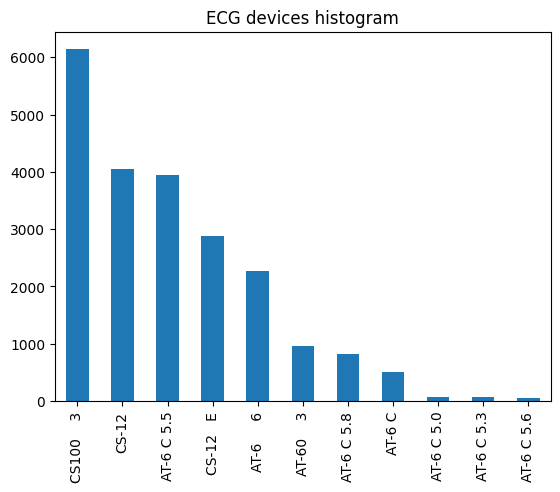

In [12]:
_ = dataset.db.device.value_counts().plot(kind='bar', title= 'ECG devices histogram')

As shown above, 11 different devices were used for performing the ECG measurements. I will encode them as numbers in order to use them as categorical features.

In [13]:
device_dict = dict(zip(device_names, range(0, len(device_names))))

dataset.db.replace({"device": device_dict}, inplace=True)

##### 1.1.1 Dealing with NaN values

I will now check columns that have NaN values and decide how to deal with them.

In [14]:
nan_cols = [i for i in dataset.db.columns if dataset.db[i].isnull().any()]
dataset.db[nan_cols].isnull().sum()

height                 14826
weight                 12379
nurse                   1475
site                      18
heart_axis              8470
infarction_stadium1    16188
infarction_stadium2    21698
validated_by            9380
baseline_drift         20202
static_noise           18541
burst_noise            21188
electrodes_problems    21771
extra_beats            19852
pacemaker              21510
dtype: int64

For most of the columns except the first 5 (`height`, `weight`, `nurse`, `site` and `heart_axis`) NaN means the attribute is not present in the corresponding ECG. This means they do not represent any missing information.

E.g. NaN value for `peacemaker` means the patient undergoing the ECG does not carry a peacemaker.

In [15]:
dataset.db["pacemaker"].unique()

array([nan, 'ja, pacemaker', 'PACE????, nan', 'ja, nan', '?, nan'],
      dtype=object)

Some of the columns will be used to filter out of data (in this case, keeping the NaN columns as the opposite of the typical analysis).

##### 1.1.2 ECG statements

As explained in the [PTB-XL publication], annotation of each `ecg_id` is done by translating the medical report `dataset.db.report` into SCP-ECG statements  `dataset.db.scp_codes` using a code to transform doctor's words into likelihoods using the following table:

<p style="text-align:center;"><img src="images/likelihood-table.png" width="75%" height="75%" />
<center>Wagner P, Strodthoff N, Bousseljot RD, Kreiseler D, Lunze FI, Samek W, Schaeffter T. PTB-XL, a large publicly available electrocardiography dataset. Sci Data. 2020 May 25;7(1):154. doi: 10.1038/s41597-020-0495-6. PMID: 32451379; PMCID: PMC7248071.
 </center>

 All these ECG-statements are grouped in one or more of the next categories: diagnostic, form (describes different shapes in the ECG signal) and rhythm (describes the cardiac rhythm). We are going to use this information to assign classes to our data for the next steps. But how do `scp_codes` look like in our data?
 
[PTB-XL Publication]:https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7248071/table/Tab2/?report=objectonly


In [16]:
dataset.db.scp_codes

ecg_id
1                 {'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}
2                             {'NORM': 80.0, 'SBRAD': 0.0}
3                               {'NORM': 100.0, 'SR': 0.0}
4                               {'NORM': 100.0, 'SR': 0.0}
5                               {'NORM': 100.0, 'SR': 0.0}
                               ...                        
21833    {'NDT': 100.0, 'PVC': 100.0, 'VCLVH': 0.0, 'ST...
21834             {'NORM': 100.0, 'ABQRS': 0.0, 'SR': 0.0}
21835                           {'ISCAS': 50.0, 'SR': 0.0}
21836                           {'NORM': 100.0, 'SR': 0.0}
21837                           {'NORM': 100.0, 'SR': 0.0}
Name: scp_codes, Length: 21801, dtype: object

Each `scp_code` is a dictionary that contains one of: diagnostic, form or rhythm, together with a likelihood for each statement following the previous table. In the case of likelihood values of zero, citing the paper: <cite>"For form and rhythm statements or in cases where no likelihood information was available, the corresponding likelihood was set to zero."</cite>
 
The distribution of the ECG-statements in the three categories can be seen here:

<p style="text-align:center;"><img src="images/venn-diagram.png" width="45%" height="45%" />
<center>Wagner P, Strodthoff N, Bousseljot RD, Kreiseler D, Lunze FI, Samek W, Schaeffter T. PTB-XL, a large publicly available electrocardiography dataset. Sci Data. 2020 May 25;7(1):154. doi: 10.1038/s41597-020-0495-6. PMID: 32451379; PMCID: PMC7248071.
 </center>

#### 1.3 Annotations

As explained in the paper, the annotations were distributed in a csv file (the `scp_statements.csv`). In our dataset object we can access it by using invoking the attribute `dataset.annotations`, getting a `pd.Dataframe` as result. We can take a look at the information contained within the dataframe.

In [17]:
print(f'Shape of the annotations dataframe{dataset.annotations.shape}')
display(dataset.annotations.head(5))

Shape of the annotations dataframe(71, 12)


,description,diagnostic,form,rhythm,diagnostic_class,diagnostic_subclass,Statement Category,SCP-ECG Statement Description,AHA code,aECG REFID,CDISC Code,DICOM Code
NDT,non-diagnostic T abnormalities,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,non-diagnostic T abnormalities,NaN,NaN,NaN,NaN
NST_,non-specific ST changes,1.0,1.0,NaN,STTC,NST_,Basic roots for coding ST-T changes and abnorm...,non-specific ST changes,145.0,MDC_ECG_RHY_STHILOST,NaN,NaN
DIG,digitalis-effect,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,suggests digitalis-effect,205.0,NaN,NaN,NaN
LNGQT,long QT-interval,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,long QT-interval,148.0,NaN,NaN,NaN
NORM,normal ECG,1.0,NaN,NaN,NORM,NORM,Normal/abnormal,normal ECG,1.0,NaN,NaN,F-000B7


The annotation dataframe has 71 rows, one for each of the ECG-statements (Diagnostic+Form+Rhythm). Each of them is used as row name (index). Let us dig in:

In [18]:
dataset.annotations.dtypes

description                       object
diagnostic                       float64
form                             float64
rhythm                           float64
diagnostic_class                  object
diagnostic_subclass               object
Statement Category                object
SCP-ECG Statement Description     object
AHA code                         float64
aECG REFID                        object
CDISC Code                        object
DICOM Code                        object
dtype: object

Most of the columns are strings that contain information about the corresponding ECG-statement (Description, statement category, SCP-ECG statement Description) as well as the mapping to other annotation standards (AHA code, aECG REFID, CDISC Code, DICOM Code). When looking at the first 5 rows, we already see a lot of NaN values:

In [19]:
dataset.annotations.isna().sum()

description                       0
diagnostic                       27
form                             52
rhythm                           59
diagnostic_class                 27
diagnostic_subclass              27
Statement Category                0
SCP-ECG Statement Description     0
AHA code                         34
aECG REFID                       48
CDISC Code                       58
DICOM Code                       58
dtype: int64

The diagnosis class and subclass have NaN values in the same positions as the diagnostic. This is due to the 27 ECG-Statements that do not belong to diagnostic, but to either form or rhythm. The last 4 columns have NaN numbers in cases when the ECG-statement does not have a corresponding code in each of the different standards. 

In [20]:
dataset.annotations.describe()

,diagnostic,form,rhythm,AHA code
count,44.0,19.0,12.0,37.000000
mean,1.0,1.0,1.0,144.297297
std,0.0,0.0,0.0,119.739037
min,1.0,1.0,1.0,1.000000
25%,1.0,1.0,1.0,60.000000
50%,1.0,1.0,1.0,140.000000
75%,1.0,1.0,1.0,162.000000
max,1.0,1.0,1.0,502.000000


The diagnostic, form and rhythm could be, again, just boolean columns containing 0 or 1 depending if that ECG-statement is included in that category. In this case, they decided to use NaN if that ECG-statement does not belong to that category. This can be determined because, as we can see here, the only value for this three columns is either 1 or NaN.

After having a comprehensive look at all of our dataset across the different tables and values, I can start preprocessing the dataset and preparing it for further analysis.

## 2. Preprocessing dataset

As stated in the [PTB-XL publication]:

>The waveform files were converted from the original proprietary format into a binary format with 16 bit precision at a resolution of 1 μV/LSB. The signals underwent minor processing to remove spikes from switch - on and switch- off processes of the devices, which were found at the beginning and the end of some recordings, and were upsampled to 500 Hz by resampling.

This preprocessed signals were then downsampled to 100 Hz for convenience. This database can be use for a lot of different purposes, as it can be seen in all the citations in the last two years of the PTB-XL publication ([see here]). Due to that, the authors decided to give the user a lot of different options for diagnosis, with different measurements of the likelihood, and even have access to the original medical reports from which the diagnosis and likelihood were extracted (see [PTB-XL publication]).

Additionally, one can decide to filter out the measurements with low quality because of electrode problems, as well as different static noise or the presence or absence of a peacemaker for each `ecg_id`, depending on the objective of your analysis. However, in my analysis I would like to keep the variability added by noisy data and feed it into the machine learning algorithm as well, since it better models reality. But I will filter out the electrode problems, as they only appear in 17 cases as outliers and their annotations are not useful.

I will focus my analysis on being able to use this data to find correlations between several variables and rationalise the result of the analysis. The main goal will be to allow automatic detection of anomalies in ECG data. As I am not particularly interested in having the most precise classification between the different heart diseases, I will only be using superclass annotations. My model aims to be the first responder to triage if there is proof for abnormalities in ECG results. In that case, it is better to have more 'False positives' than 'False negatives': we want to capture all the cases in which the ECG is escaping the normal behaviour, so we are not leaving any patient with potential heart issues out. After that, a professional doctor or another algorithm can take a look at these cases and give a more precise diagnosis to help the patient.

[PTB-XL publication]: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7248071/
[see here]:https://pubmed.ncbi.nlm.nih.gov/?linkname=pubmed_pubmed_citedin&from_uid=32451379

### 2.1 Pre-diagnosis filtering

The publication also describes several methods for filtering out the dataset. I decided to only filter the ones that do not have human validation (`validated_by_human` equals False) as well as the ones which experience some problem with the electrodes during the measurements (`electrodes_problems` is not NaN).

#### 2.1.1 Filtering out samples not validated by humans
As the process for obtaining the SCP-ECG Statements is already a little bit arbitrary, we are not going to use the samples in which no human validated the different ECG statements. The publication mentions that 73.7% of the dataset is validated by human, so it will not suppose a huge lose. Let us make sure:

In [21]:
dataset.db.validated_by_human.value_counts()

True     16058
False     5743
Name: validated_by_human, dtype: int64

In [22]:
filtered_db = dataset.db[dataset.db.validated_by_human]

#### 2.1.2 Filtering out samples with electrode problems
As already explained before, electrode problems can be considered outliers so I will remove them to continue with the analysis.

In [23]:
filtered_db.electrodes_problems.isna().value_counts()

True     16029
False       29
Name: electrodes_problems, dtype: int64

In [24]:
filtered_db = filtered_db[filtered_db.electrodes_problems.isna()]

### 2.2 Annotation of superclasses

I am going to annotate our data just following the 5 superclasses, and we will annotate it using just the diagnosis ECG-statement, ignoring the rhythm and form. 

4 SCP-ECG Statements are shared between _Diagnosis_ and _Form. The publication mentions that such statements are annotated with likelihood 0. Therefore, in order to tell them appart from missing diagnostic statement, we set the likelihood value to 5 for this cases. This is an important step, as we will now generate 5 columns, one for each superclass with its associated likelihood value. As counterpart, missing statements will have value 0 for the respective superclass.

In [25]:
import pandas as pd

# We filter the statements that do not have any diagnosis assigned.
# As mentioned before, this column equals one in the ECG-statements that
# correspond to diagnosis and NaN otherwise.
filtered_annotations = dataset.annotations[dataset.annotations.diagnostic == 1]

# Diagnostic superclasses present in the annotations
superclasses = ['NORM', 'MI', 'STTC', 'CD', 'HYP']


def assign_diagnostic(current_sample):
    """Adds one column for each superclass with a likelihood value.
    """
    # To assign the superclass associated at each ecg_id, we need to take a look
    # at the scp_codes dictionary, which is a dictionary with likelihoods.
    scp_dict = current_sample.scp_codes
    # We assign likelihood 0 as default. It will stay this way if the superclass
    # is not present in the scp_codes detected for each sample.
    columns = {superclass: 0 for superclass in superclasses}
    # We iterate for all the scp codes annotated for the current ecg_id
    for scp_code, likelihood in scp_dict.items():
        # As we are only interested in the ones that have diagnosis, we check
        # if that scp_code is included in my filtered annotated dataframe
        if scp_code in filtered_annotations.index:
            # we add the class to a list of classes, with the corresponding
            # likelihood as a tuple.
            superclass = filtered_annotations.loc[scp_code].diagnostic_class
            # Assign 5 for the diagnostic coming from FORM statements
            if likelihood == 0:
                value = 5
            # Otherwise, use the original likelihood inside the scp_code dict
            else:
                value = likelihood
            # If likelihood is giving several times for different statements 
            # with the same superclass, take the maximum
            columns[superclass] = max(columns[superclass], value)

    # We return the superclass with a dictionary
    return pd.Series(list(columns.values()))


In [26]:
# Apply diagnostic superclass
new_columns = filtered_db.apply(assign_diagnostic, axis=1)
new_columns.columns = superclasses
diagnosed_db = filtered_db.join(new_columns)
diagnosed_db.head()


,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,Q-ISC-V2V3,Q-ISC-RPeak,STRAIN,MI-ALL,record,NORM,MI,STTC,CD,HYP
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,0,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,False,False,False,False,<wfdb.io.record.Record object at 0x7fa4af5ae910>,100.0,0.0,0.0,0.0,0.0
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,0,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,False,False,False,False,<wfdb.io.record.Record object at 0x7fa4af5ae5e0>,80.0,0.0,0.0,0.0,0.0
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,0,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,False,False,False,False,<wfdb.io.record.Record object at 0x7fa4af5ae8e0>,100.0,0.0,0.0,0.0,0.0
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,0,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,False,False,False,False,<wfdb.io.record.Record object at 0x7fa4af5ae970>,100.0,0.0,0.0,0.0,0.0
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,0,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,False,False,False,False,<wfdb.io.record.Record object at 0x7fa4af5aeb50>,100.0,0.0,0.0,0.0,0.0


### 2.3 Filtering out ECGs without diagnosis

After labeling our data, we filter out the samples that does not have any label.

In [27]:
# diagnosed_db[diagnosed_db.NORM==0 & diagnosed_db.MI==0 & diagnosed_db.STTC==0 & diagnosed_db.CD==0 & diagnosed_db.HYP==0]
conditions = (diagnosed_db.NORM==0) & (diagnosed_db.MI==0) & (diagnosed_db.STTC==0) & (diagnosed_db.CD==0) & (diagnosed_db.HYP==0)
sum(conditions)

153

Only 153 samples do not have any labeling. Let's remove them:

In [28]:
diagnosed_filtered_db = diagnosed_db[~conditions]

These samples describe different abnormalities that belong to rhythm or form SCP-Statements, already filtered out from the annotations with `diagnostic==1`. This data still contains interesting information and could be used to detect any anormality in the ECG that is deviating from the normal behaviour but without a clear diagnostic. For keeping it simple and making this doable in the time frame that we have, I decided to remove them.


## 3. Plot signal for the doctor

There are lots of dangers when there is no communication or understanding ammong people working on the bench, wet scientists, doctors and data scientists. I took some time refreshing my knowledge about the physiology of the heart, as well as learning about the ECG data, in particular the [12-lead ECG] format. After understanding the different characteristics of the ECG, the electrode placement and lead calculations, I decided to use the Cabrera format for plotting the ECG, as it is widely used by doctors and it helps them interpreting the ECG more efficiently. It has two strong points:
* The leads are anatomically ordered in the ECG representation
* Uses -aVR instead of aVR: The inversion of the aVR lead also helps with the ECG representation and it makes it easier to diagnose the acute ischemia, and also fills the gap between the lead I and II so all the leads equidist 30° in normal axis (Current standard is -30° to +90° degrees)
<!-- !![AXIS](images/The-hexaxial-reference-system-Note-that-the-position-of-each-limb-lead-is-calculated.png) -->
<p style="text-align:center;"><img src="images/The-hexaxial-reference-system-Note-that-the-position-of-each-limb-lead-is-calculated.png" width="40%" height="40%" />
<center>Sampson, Michael. (2016). Understanding the ECG. Part 6: QRS axis. British Journal of Cardiac Nursing. 11. 180-188. 10.12968/bjca.2016.11.4.180. </center>

[12-lead ECG]:https://ecgwaves.com/topic/ekg-ecg-leads-electrodes-systems-limb-chest-precordial/

In [29]:
import ecg_plot


def plot_ecg_for_doctor(df: pd.DataFrame, ecg_id: int):
    current_ecg = df.loc[ecg_id]
    # We invert the aVR value in the record as it has several advantages
    # and it is broadly used in the ecg representation
    # p_signal has shape m x n, in which m is length of signal and n is
    # number of leads. To invert aVR, we need n x m instead.
    # This new dimension is also needed for the graphical representation
    # with ecg_plot
    p_signal_t = current_ecg.record.p_signal.T
    sig_name = current_ecg.record.sig_name
    cabrera_ecg = {
        'aVL': p_signal_t[sig_name.index('AVL')],
        'V1': p_signal_t[sig_name.index('V1')],
        'I': p_signal_t[sig_name.index('I')],
        'V2': p_signal_t[sig_name.index('V2')],
        '-aVR': -p_signal_t[sig_name.index('AVR')],
        'V3': p_signal_t[sig_name.index('V3')],
        'II': p_signal_t[sig_name.index('II')],
        'V4': p_signal_t[sig_name.index('V4')],
        'aVF': p_signal_t[sig_name.index('AVF')],
        'V5': p_signal_t[sig_name.index('V5')],
        'III': p_signal_t[sig_name.index('III')],
        'V6': p_signal_t[sig_name.index('V6')],
    }
    # We represent the data using Cabrera format for doctors with the
    # inverted aVR for easier ECG interpretation
    labels = ','.join(
        f" {superclass}: {current_ecg[superclass]}"
        for superclass in superclasses if current_ecg[superclass] != 0
    )
    args = {
        # We get the physical signal from the record for the selected ecg
        # ecg_plot uses m x n ECG signal data, which m is number of leads
        # and n is length of signal.
        'ecg': list(cabrera_ecg.values()),
        'sample_rate': sampling_rate.value.rate,
        'title':
            f'12-lead ECG in Cabrera format (ECG ID: {ecg_id}, {labels})',
        'lead_index': list(cabrera_ecg.keys()),
    }
    ecg_plot.plot_12(**args)


We plot one representative ECG for each type of disease (superclass) to take a better look at the diffferences between them. Representative ECG is selected  by choosing ECGs with 100 likelihood for each category and 0 likelihood for the rest of the categories (if possible).

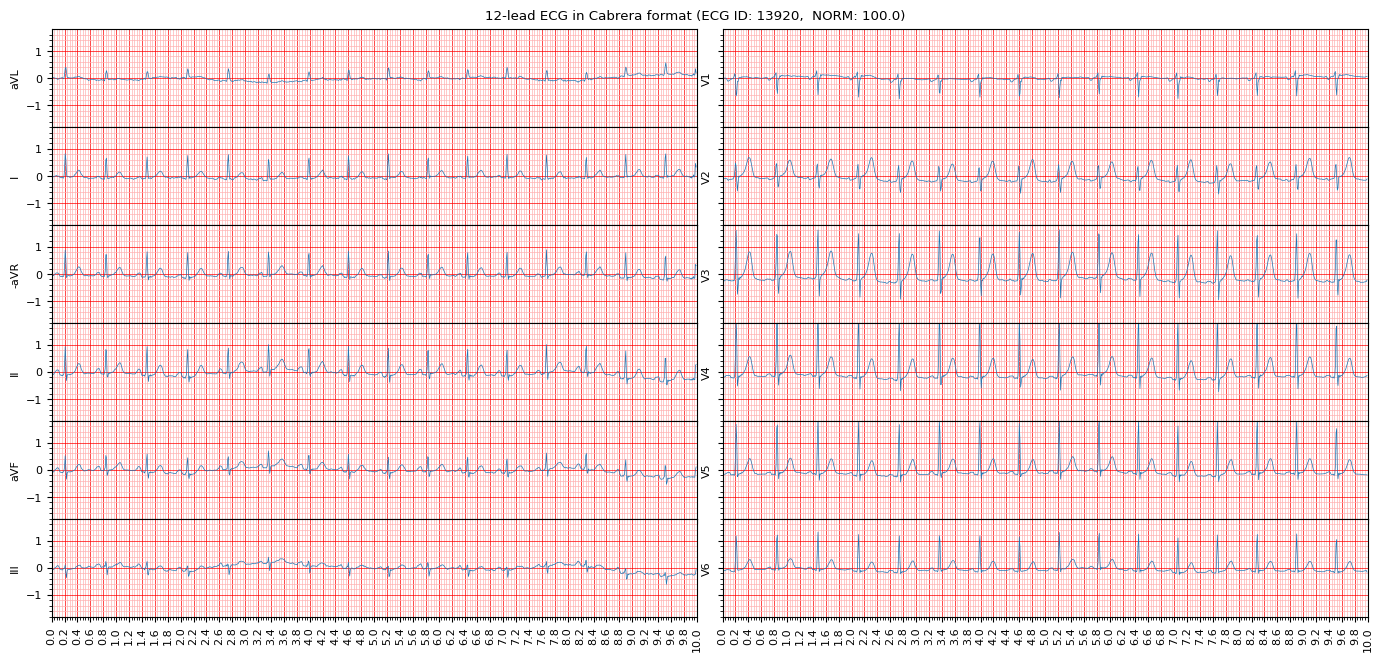

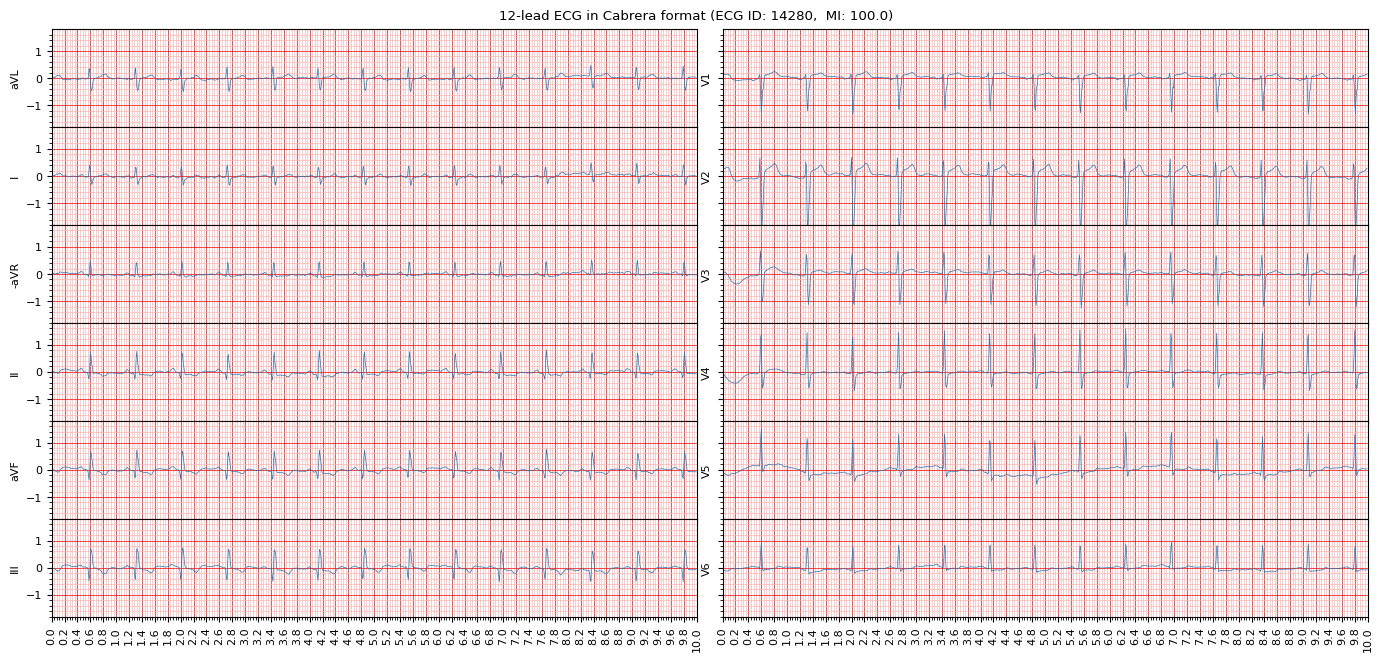

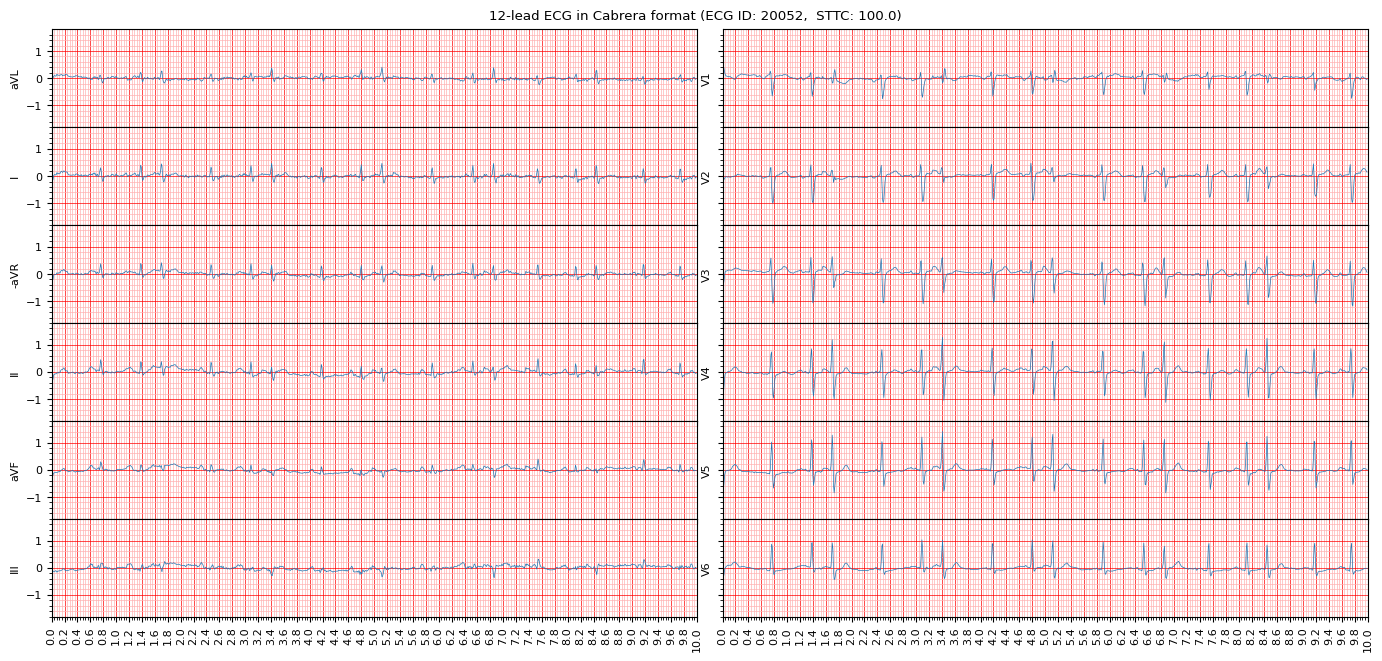

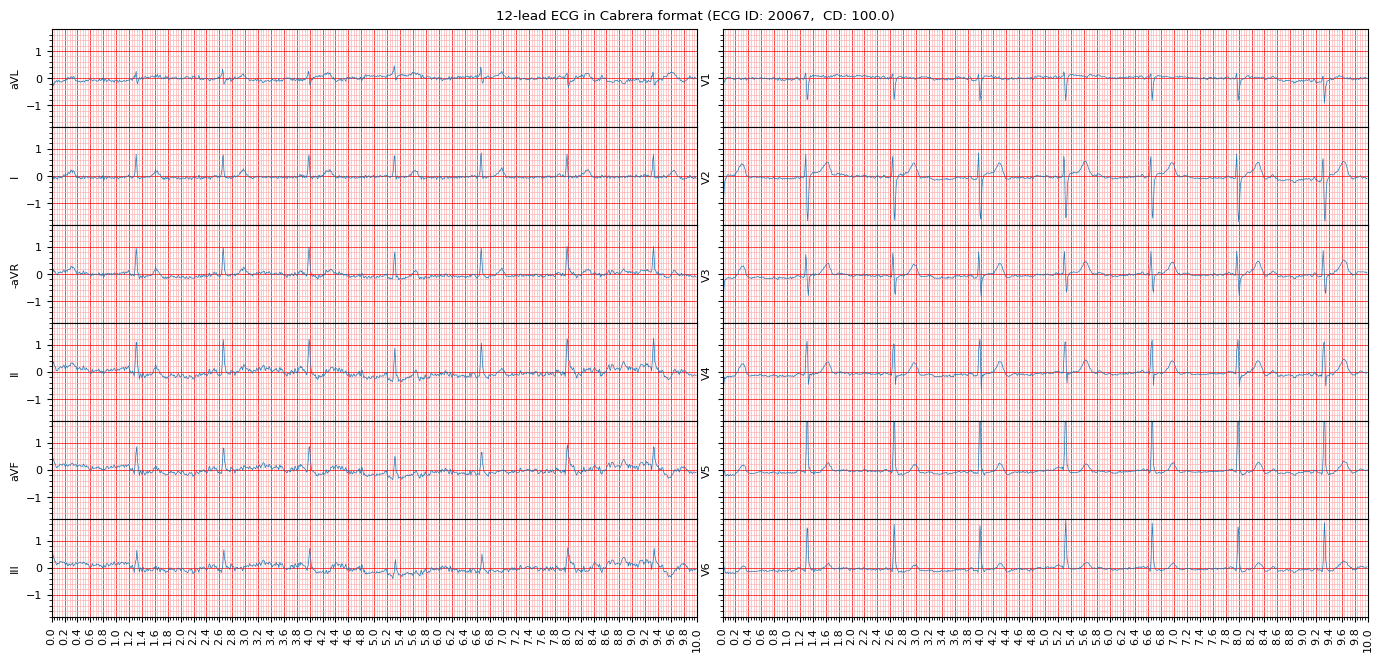

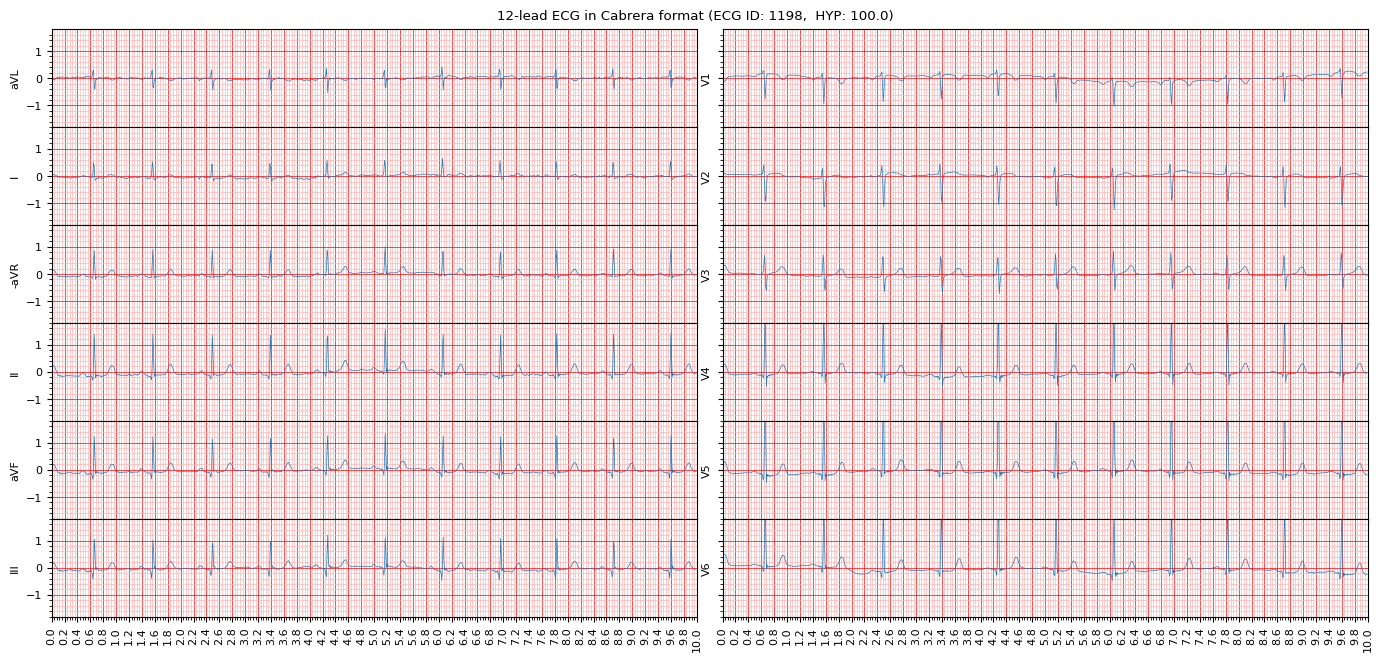

In [30]:
for superclass in superclasses:
    other_superclasses = [s for s in superclasses if s != superclass]
    condition = diagnosed_filtered_db[superclass] == 100
    for other in other_superclasses:
        condition = (condition) & (diagnosed_filtered_db[other] == 0)

    sample = diagnosed_filtered_db[condition].sample()
    plot_ecg_for_doctor(diagnosed_filtered_db, sample.index[0])


## 4. Identifying the heart beat
### Calculation and annotations of different metrics associated with the heart rate

It would be interesting to make a comparative study of all the algorithms available for heart rate calculations, or even compute one ourselves that will fit best our current dataset. Due to time constraint, I decided to use the [Heartpy] Python package. Even though Heartpy truly shines with PPG data, it also performs better than traditional algorithms for ECGs (such as Pan-Tompkins and HRVAS ECGViewer) as shown in its [publication]:

|                     | RMSE peak location | RMSE peak-peak intervals | RMSE BPM | RMSE SDSD |
|---------------------|--------------------|--------------------------|----------|-----------|
| Developed algorithm | 0.16               | 6.38                     | 0.41     | 221.79    |
| Pan-Tompkins        | 6.84               | 335.25                   | 3.07     | 371.38    |
| HRVAS ECGViewer     | 3.64               | 97.34                    | 1.88     | 231.96    |

There is a lot of literature available about different algorithms benchmarked against each other [[1],[2]]. Trying another higher score algorithm like Two Peak Detector could be an interesting option for developing a more accurate pipeline if more time was available.

**For all HR analysis, I will be using the Lead II as input, as it has been described in the literature as the best one for detecting heart rate and rhythm**[[3],[4]].


[Heartpy]: https://python-heart-rate-analysis-toolkit.readthedocs.io/en/latest/
[publication]: https://www.sciencedirect.com/science/article/abs/pii/S1369847818306740
[1]: https://www.mdpi.com/1424-8220/21/24/8174
[2]: https://github.com/berndporr/py-ecg-detectors
[3]: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1122339/
[4]: https://aacnjournals.org/ajcconline/article-abstract/29/3/237/30937/Arrhythmia-Diagnosis-and-the-12-Lead?redirectedFrom=fulltext 


### 4.1 Preprocessing ECG signal

In [31]:
import heartpy as hp

In order to check how Heartpy improves noisy data, let's test the Heart Rate detection before and after the following transformations:
* Removing baseline drift
* Enhancing peaks

I will test it in three examples: 
1. Random sample containing baseline drift
1. Random sample with static noise
1. Random sample without noise

#### 4.1.1 Random sample containing baseline drift


/mnt/d/Documentos 2022/idoven/Idoven-Data-Scientist/.venv/lib/python3.8/site-packages/numpy/ma/core.py:5288: RuntimeWarning: Mean of empty slice.
  result = super().mean(axis=axis, dtype=dtype, **kwargs)[()]
/mnt/d/Documentos 2022/idoven/Idoven-Data-Scientist/.venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


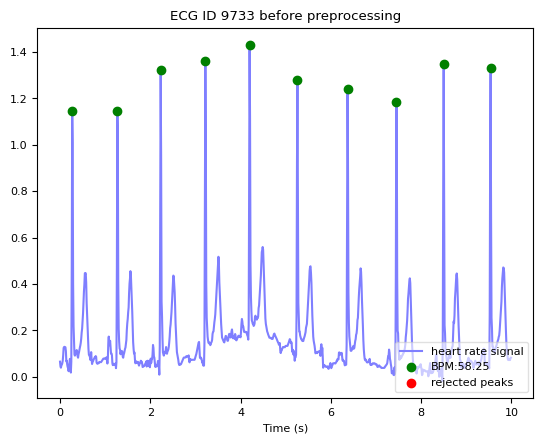

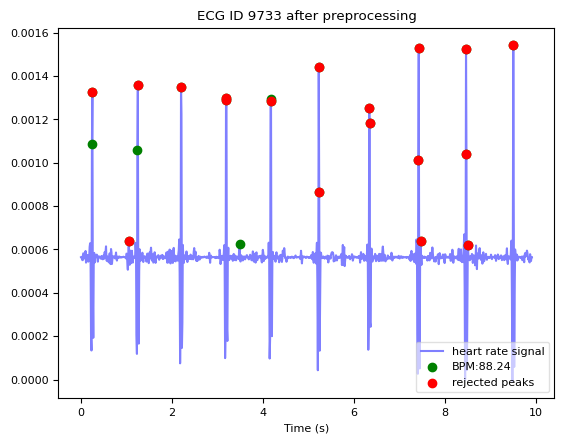

In [32]:
# Baseline drift
rand_ecg = diagnosed_filtered_db[
    diagnosed_filtered_db.baseline_drift.notna()].sample()
rand_ecg_id = rand_ecg.index[0]

data = diagnosed_filtered_db.loc[rand_ecg_id].record.p_signal
lead = diagnosed_filtered_db.loc[rand_ecg_id].record.sig_name.index('II')

# We took lead II
wd, measurements = hp.process(data.T[lead], sampling_rate.value.rate)

# visualise in plot of custom size
hp.plotter(wd, measurements, title=f'ECG ID {rand_ecg_id} before preprocessing')

pre_processed_data = hp.remove_baseline_wander(
    data.T[lead], sampling_rate.value.rate)
pre_processed_data = hp.preprocessing.enhance_ecg_peaks(
    data.T[lead], sampling_rate.value.rate)
wd, measurements = hp.process(
    pre_processed_data, sampling_rate.value.rate)

# visualise in plot of custom size
plot2 = hp.plotter(
    wd, measurements, title=f'ECG ID {rand_ecg_id} after preprocessing')


#### 4.1.2 Random sample with static noise

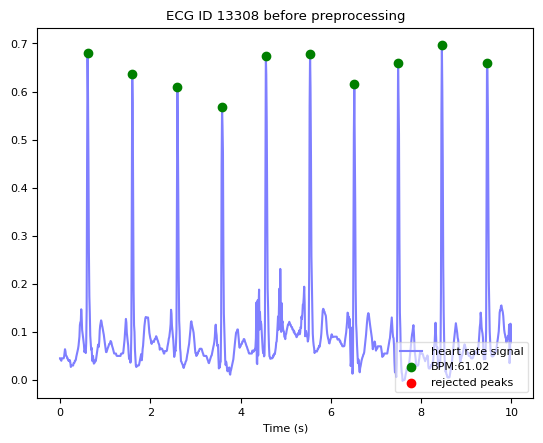

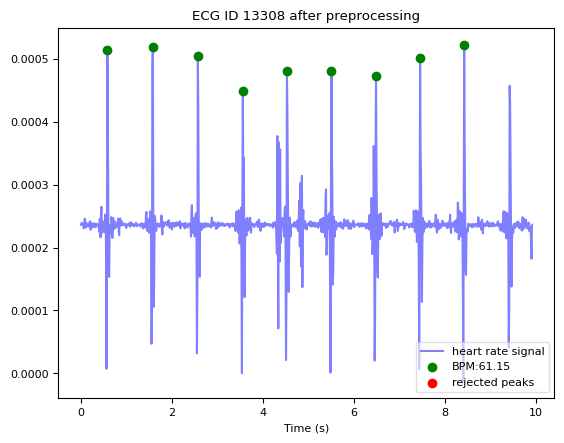

In [33]:
# Static noise
rand_ecg = diagnosed_filtered_db[
    diagnosed_filtered_db.static_noise.notna()].sample()
rand_ecg_id = rand_ecg.index[0]

data = diagnosed_filtered_db.loc[rand_ecg_id].record.p_signal
lead = diagnosed_filtered_db.loc[rand_ecg_id].record.sig_name.index('II')

# We took lead II
wd, measurements = hp.process(data.T[lead], sampling_rate.value.rate)

# visualise in plot of custom size
hp.plotter(wd, measurements, title=f'ECG ID {rand_ecg_id} before preprocessing')

pre_processed_data = hp.remove_baseline_wander(
    data.T[lead], sampling_rate.value.rate)
pre_processed_data = hp.preprocessing.enhance_ecg_peaks(
    data.T[lead], sampling_rate.value.rate)
wd, measurements = hp.process(
    pre_processed_data, sampling_rate.value.rate)

# visualise in plot of custom size
plot2 = hp.plotter(
    wd, measurements, title=f'ECG ID {rand_ecg_id} after preprocessing')


#### 4.1.3 Random sample without noise

/mnt/d/Documentos 2022/idoven/Idoven-Data-Scientist/.venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/d/Documentos 2022/idoven/Idoven-Data-Scientist/.venv/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


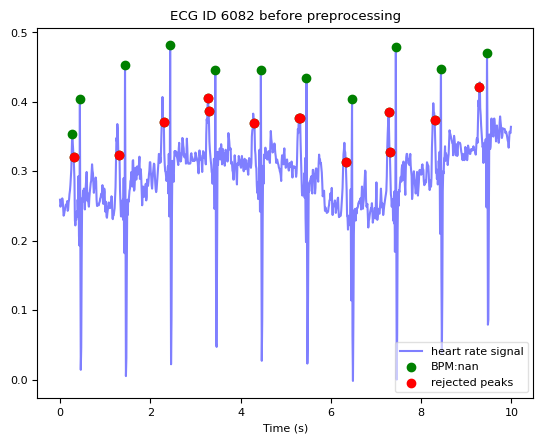

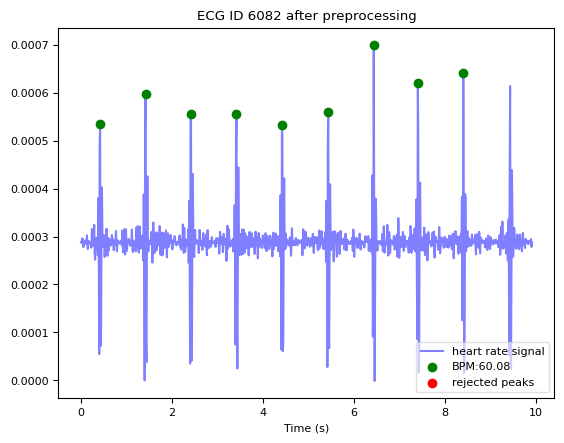

In [34]:
# Without noise

conditions = (diagnosed_filtered_db.static_noise.isna()) & (
    diagnosed_filtered_db.burst_noise.isna()) & (
        diagnosed_filtered_db.baseline_drift.isna())

rand_ecg = diagnosed_filtered_db[conditions].sample()
rand_ecg_id = rand_ecg.index[0]

data = diagnosed_filtered_db.loc[rand_ecg_id].record.p_signal
lead = diagnosed_filtered_db.loc[rand_ecg_id].record.sig_name.index('II')

# We took lead II
wd, measurements = hp.process(data.T[lead], sampling_rate.value.rate)

# visualise in plot of custom size
hp.plotter(wd, measurements, title=f'ECG ID {rand_ecg_id} before preprocessing')

pre_processed_data = hp.remove_baseline_wander(
    data.T[lead], sampling_rate.value.rate)
pre_processed_data = hp.preprocessing.enhance_ecg_peaks(
    data.T[lead], sampling_rate.value.rate)
wd, measurements = hp.process(
    pre_processed_data, sampling_rate.value.rate)

# visualise in plot of custom size
plot2 = hp.plotter(
    wd, measurements, title=f'ECG ID {rand_ecg_id} after preprocessing')

### 4.2 Computing Heart Rate measurements


Heartpy allow us to compute not only the average heart rate (BPM) but also many additional heart rythm measures. I will use the most robustly detected ones to annotate our data (BPM, IBI, SDNN and HR MAD).

Here is an excerp from the [Heartpy publication] with the definition of each variable (in bold):
> Common measures expressing the HR found in the literature are the beats per minute (**BPM**) and the mean inter-beat
interval (**IBI**). HRV is expressed by the median absolute deviation of intervals between heart beats (**MAD**), the standard deviation
of intervals between heart beats (**SDNN**), the root mean square of successive differences between neighbouring heart
beat intervals (**RMSSD**), the standard deviation of successive differences between neighbouring heart beat intervals (**SDSD**),
and the proportion of differences between successive heart beats greater than 50 ms and 20 ms (**pNN50**, **pNN20**, resp.). HRV
can also be expressed in the frequency domain, where two frequency bands are usually included: low frequency (**LF**, 0.04–
0.15 Hz), which is related to **short-term blood pressure variation** (Bernardi et al., 1994), and high frequency (**HF**, 0.16–0.5Hz),
which is a reflection of **breathing rate**

[Heartpy publication]: https://www.sciencedirect.com/science/article/abs/pii/S1369847818306740

In [35]:
key_measurements = ['bpm', 'ibi', 'sdnn', 'hr_mad']
failed_ids = list()


def compute_heart_rate(current_ecg):
    signal = current_ecg.record.p_signal
    # We took lead II
    lead = current_ecg.record.sig_name.index('II')
    try:
        _, measurements = hp.process(signal.T[lead], sampling_rate.value.rate)
    except:
        failed_ids.append(current_ecg.name)
        return pd.Series(len(key_measurements) * [np.nan])
    return pd.Series([v
                      for k, v in measurements.items()
                      if k in key_measurements])


# Apply heart rate calculations
new_columns = diagnosed_filtered_db.apply(compute_heart_rate, axis=1)
new_columns.columns = key_measurements

heart_rate_db = diagnosed_filtered_db.join(new_columns)
heart_rate_db.head()


/mnt/d/Documentos 2022/idoven/Idoven-Data-Scientist/.venv/lib/python3.8/site-packages/scipy/interpolate/_fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,record,NORM,MI,STTC,CD,HYP,bpm,ibi,sdnn,hr_mad
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,0,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,<wfdb.io.record.Record object at 0x7fa4af5ae910>,100.0,0.0,0.0,0.0,0.0,168.000000,357.142857,222.178454,240.0
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,0,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,<wfdb.io.record.Record object at 0x7fa4af5ae5e0>,80.0,0.0,0.0,0.0,0.0,277.777778,216.000000,60.860496,70.0
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,0,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,<wfdb.io.record.Record object at 0x7fa4af5ae8e0>,100.0,0.0,0.0,0.0,0.0,63.754427,941.111111,20.786985,20.0
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,0,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,<wfdb.io.record.Record object at 0x7fa4af5ae970>,100.0,0.0,0.0,0.0,0.0,172.131148,348.571429,170.748652,190.0
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,0,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,<wfdb.io.record.Record object at 0x7fa4af5aeb50>,100.0,0.0,0.0,0.0,0.0,66.298343,905.000000,47.592016,40.0


In [36]:
print(
    f'Samples for which heart rate could not be determined: {len(failed_ids)}')
for id in failed_ids:
    print(f'ID: {id}')

Samples for which heart rate could not be determined: 22
ID: 281
ID: 652
ID: 1180
ID: 3166
ID: 4496
ID: 5249
ID: 9205
ID: 9854
ID: 10623
ID: 11830
ID: 11923
ID: 12224
ID: 12443
ID: 13302
ID: 14286
ID: 14932
ID: 15573
ID: 17304
ID: 18295
ID: 18636
ID: 20583
ID: 20646


For processing this new data, I will remove the ECG samples that have failed in the heart rate calculation. We could investigate further into each of the cases to understand the problem and fix it and try different methods, but as they are so few and I don't have enough time, that I will simply drop them.


In [37]:
heart_rate_db.drop(labels=failed_ids, axis=0, inplace=True)

Now, I will check if any of the new measurements added has any additional NaN value.

In [38]:
heart_rate_db[key_measurements].isna().sum()

bpm       159
ibi       159
sdnn      159
hr_mad    159
dtype: int64

Again, this should be treated more carefully with a deeper analysis. But since the amount of faulty samples is relatively small we can simply drop them for the sake of time.

In [39]:
heart_rate_db = heart_rate_db[heart_rate_db[key_measurements[0]].notna()]

## 5. Identifying QRS complex and annotation

The package [neurokit2] is build for working with biological signals. It has shown good results annotating QRS complexes so let us use it for this purpose.

[neurokit2]:https://neuropsychology.github.io/NeuroKit/introduction.html

In [40]:
import neurokit2 as nk

#### 5.1 Find R peaks



In [41]:
# Extract R-peaks locations with one example

current_id = diagnosed_filtered_db.sample().index[0]
current_record = diagnosed_filtered_db.loc[current_id].record
lead = current_record.sig_name.index('II')
ecg_signal = current_record.p_signal.T[lead]
_, rpeaks = nk.ecg_peaks(ecg_signal, sampling_rate=sampling_rate.value.rate)

In [42]:
rpeaks

{'ECG_R_Peaks': array([101, 189, 277, 363, 451, 541, 631, 718, 806, 894, 981]),
 'sampling_rate': 100}

#### 5.2 Annote QRS complex + P and T waves

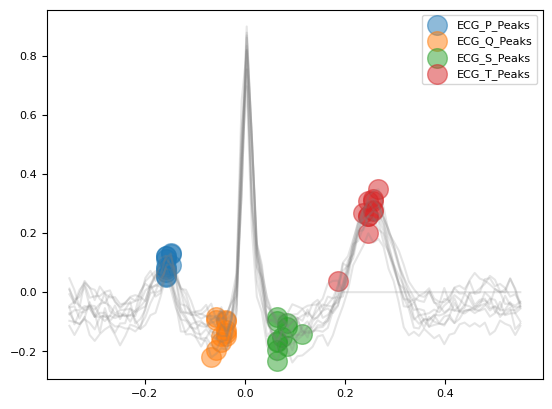

In [43]:
# Delineate the ECG signal with one example and visualizing all peaks of ECG complexes
_, waves_peak = nk.ecg_delineate(ecg_signal, 
                                 rpeaks, 
                                 sampling_rate=sampling_rate.value.rate, 
                                 method="peak", 
                                 show=True, 
                                 show_type='peaks')

In [44]:
waves_peak.keys()

dict_keys(['ECG_P_Peaks', 'ECG_Q_Peaks', 'ECG_S_Peaks', 'ECG_T_Peaks', 'ECG_P_Onsets', 'ECG_T_Offsets'])

We annotate the QRS complex and the P and T waves in our dataset:

In [45]:
key_peaks = ['ECG_R_Peaks', 'ECG_P_Peaks', 'ECG_Q_Peaks', 'ECG_S_Peaks', 'ECG_T_Peaks', 'ECG_P_Onsets', 'ECG_T_Offsets']
failed_ids = list()

def annotate_QRS(current_ecg):
    current_record = current_ecg.record
    lead = current_record.sig_name.index('II')
    ecg_signal = current_record.p_signal.T[lead]
    try:
        _, rpeaks = nk.ecg_peaks(ecg_signal, sampling_rate=sampling_rate.value.rate)
        _, waves_peak = nk.ecg_delineate(
            ecg_signal, rpeaks, sampling_rate=sampling_rate.value.rate, method="peak")
        all_peaks = {**rpeaks, **waves_peak}
    except: 
        failed_ids.append(current_ecg.name)
        return pd.Series(len(key_peaks) * [np.nan])
    return pd.Series([v for k,v in all_peaks.items() if k in key_peaks])

In [46]:
# Apply QRS annotation
new_columns = diagnosed_filtered_db.apply(annotate_QRS, axis=1)
new_columns.columns = key_peaks
annotated_db = diagnosed_filtered_db.join(new_columns)
annotated_db.head()


/mnt/d/Documentos 2022/idoven/Idoven-Data-Scientist/.venv/lib/python3.8/site-packages/neurokit2/signal/signal_period.py:68: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/mnt/d/Documentos 2022/idoven/Idoven-Data-Scientist/.venv/lib/python3.8/site-packages/neurokit2/signal/signal_period.py:68: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/mnt/d/Documentos 2022/idoven/Idoven-Data-Scientist/.venv/lib/python3.8/site-packages/neurokit2/signal/signal_period.py:68: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/mnt/d/Documentos 2022/idoven/Idoven-Data-Scientist/.venv/lib/python3.8/site-packages/neurokit2/signal/signal_period.py:68: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/mnt/d/Documentos 2022/idoven/Idoven-Data-Scientist/.venv/lib/python3.8/site-packages/neurokit2/signal/signal_period.py:68: NeuroKit

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,STTC,CD,HYP,ECG_R_Peaks,ECG_P_Peaks,ECG_Q_Peaks,ECG_S_Peaks,ECG_T_Peaks,ECG_P_Onsets,ECG_T_Offsets
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,0,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,0.0,0.0,0.0,"[115, 208, 300, 393, 487, 583, 679, 773, 864, ...","[101, 194, 290, 379, 477, 569, 667, 762, 851, ...","[112, 204, 297, 389, 485, 580, 672, 770, 859, ...","[127, 218, 303, 399, 492, 588, 684, 777, 869, ...","[143, 236, 328, 422, 515, 611, 707, 802, 892, ...","[96, 191, 281, 376, 468, 566, 665, 752, 836, 944]","[151, 243, 333, 428, 525, 619, 715, 809, 898, ..."
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,0,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,0.0,0.0,0.0,"[101, 231, 368, 502, 627, 747, 863]","[87, 216, 354, 488, 610, 733, 848]","[97, 227, 364, 494, 624, 744, 860]","[103, 233, 370, 504, 638, 749, 875]","[129, 259, 396, 530, 655, 773, 890]","[83, 212, 339, 477, 597, 728, 826]","[137, 266, 405, 538, 664, 783, 899]"
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,0,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,0.0,0.0,0.0,"[104, 202, 298, 394, 485, 577, 670, 764, 857, ...","[91, 188, 285, 381, 469, 564, 658, 751, 842, 937]","[101, 198, 294, 390, 479, 573, 666, 760, 853, ...","[111, 206, 304, 397, 489, 581, 674, 775, 861, ...","[136, 233, 328, 424, 516, 608, 701, 794, 885, ...","[88, 179, 282, 378, 456, 560, 654, 740, 829, 935]","[147, 237, 336, 438, 521, 613, 706, 799, 894, ..."
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,0,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,0.0,0.0,0.0,"[108, 191, 279, 364, 446, 522, 601, 680, 762, ...","[94, 177, 265, 350, 432, 508, 587, 657, 748, 8...","[102, 188, 275, 361, 442, 519, 597, 660, 759, ...","[112, 195, 282, 369, 450, 527, 605, 684, 766, ...","[131, 214, 302, 387, 469, 545, 623, 704, 787, ...","[86, 172, 259, 346, 429, 502, 581, 654, 734, 8...","[141, 221, 307, 393, 480, 554, 630, 710, 791, ..."
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,0,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,0.0,0.0,0.0,"[33, 123, 219, 313, 399, 482, 571, 669, 764, 8...","[23, 110, 207, 300, 385, 468, 558, 656, 751, 8...","[27, 117, 215, 310, 396, 475, 566, 665, 760, 8...","[40, 129, 227, 316, 403, 488, 580, 675, 771, 8...","[59, 149, 246, 339, 425, 508, 598, 696, 791, 8...","[9, 99, 202, 295, 380, 464, 554, 640, 746, 827...","[65, 159, 252, 346, 432, 514, 603, 703, 796, 8..."


In [56]:
failed_ids

[3166, 7001, 11853, 12217, 16700, 19113]

In [55]:
annotated_db[key_peaks].isna().sum()

ECG_R_Peaks      6
ECG_P_Peaks      6
ECG_Q_Peaks      6
ECG_S_Peaks      6
ECG_T_Peaks      6
ECG_P_Onsets     6
ECG_T_Offsets    6
dtype: int64

It fails only in 6 of the total samples and it does not return any additional NaN values. We can filter them out:

In [61]:
annotated_db.drop(labels=failed_ids, axis=0, inplace=True)

 Since we observed Heartpy still fails to compute the heart rate values for some of the samples, and we can see how good the peak annotation with the Neurokit2 and that it have less problems, it could be used for BPM calculations. Here we have an example using the wfdb package:

In [60]:
import wfdb.processing 

hr_array = wfdb.processing.compute_hr(len(ecg_signal), rpeaks['ECG_R_Peaks'], sampling_rate.value.rate)

As by definition, BPM is the number of heart beats per minute and rpeaks['ECG_R_Peaks'] contains the peaks found in 10 seconds, multiplying the number of peaks found for 6 will give us the BPM. We can annotate the dataframe with this:

In [65]:
def compute_BPM(rpeaks):
    return len(rpeaks['ECG_R_Peaks'])*6

# Apply BPM calculation
new_column = annotated_db.apply(compute_BPM, axis=1)
new_columns.column = 'BPM'
annotated_db = diagnosed_filtered_db.join(new_columns)
annotated_db.head()

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,STTC,CD,HYP,ECG_R_Peaks,ECG_P_Peaks,ECG_Q_Peaks,ECG_S_Peaks,ECG_T_Peaks,ECG_P_Onsets,ECG_T_Offsets
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,0,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,0.0,0.0,0.0,"[115, 208, 300, 393, 487, 583, 679, 773, 864, ...","[101, 194, 290, 379, 477, 569, 667, 762, 851, ...","[112, 204, 297, 389, 485, 580, 672, 770, 859, ...","[127, 218, 303, 399, 492, 588, 684, 777, 869, ...","[143, 236, 328, 422, 515, 611, 707, 802, 892, ...","[96, 191, 281, 376, 468, 566, 665, 752, 836, 944]","[151, 243, 333, 428, 525, 619, 715, 809, 898, ..."
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,0,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,0.0,0.0,0.0,"[101, 231, 368, 502, 627, 747, 863]","[87, 216, 354, 488, 610, 733, 848]","[97, 227, 364, 494, 624, 744, 860]","[103, 233, 370, 504, 638, 749, 875]","[129, 259, 396, 530, 655, 773, 890]","[83, 212, 339, 477, 597, 728, 826]","[137, 266, 405, 538, 664, 783, 899]"
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,0,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,0.0,0.0,0.0,"[104, 202, 298, 394, 485, 577, 670, 764, 857, ...","[91, 188, 285, 381, 469, 564, 658, 751, 842, 937]","[101, 198, 294, 390, 479, 573, 666, 760, 853, ...","[111, 206, 304, 397, 489, 581, 674, 775, 861, ...","[136, 233, 328, 424, 516, 608, 701, 794, 885, ...","[88, 179, 282, 378, 456, 560, 654, 740, 829, 935]","[147, 237, 336, 438, 521, 613, 706, 799, 894, ..."
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,0,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,0.0,0.0,0.0,"[108, 191, 279, 364, 446, 522, 601, 680, 762, ...","[94, 177, 265, 350, 432, 508, 587, 657, 748, 8...","[102, 188, 275, 361, 442, 519, 597, 660, 759, ...","[112, 195, 282, 369, 450, 527, 605, 684, 766, ...","[131, 214, 302, 387, 469, 545, 623, 704, 787, ...","[86, 172, 259, 346, 429, 502, 581, 654, 734, 8...","[141, 221, 307, 393, 480, 554, 630, 710, 791, ..."
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,0,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,0.0,0.0,0.0,"[33, 123, 219, 313, 399, 482, 571, 669, 764, 8...","[23, 110, 207, 300, 385, 468, 558, 656, 751, 8...","[27, 117, 215, 310, 396, 475, 566, 665, 760, 8...","[40, 129, 227, 316, 403, 488, 580, 675, 771, 8...","[59, 149, 246, 339, 425, 508, 598, 696, 791, 8...","[9, 99, 202, 295, 380, 464, 554, 640, 746, 827...","[65, 159, 252, 346, 432, 514, 603, 703, 796, 8..."


I will conclude that using the Neurokit2 package will allow us to have a more precise annotation of all the ECG waves and peaks, and having more time to master it will result in really good results when processing ECG signals. 

## 6. Deeper analysis of the data obtained

### 6.1 Correlation studies

With this huge amount of data, lots of possibilities are open for more annotations. I would love to make some correlation analysis with all the features and take a look at some heatmaps to try and understand the depths of the data. 

### 6.2 Machine learning

I have already prepared my dataset to train a multioutput regression model using the superclass columns with likelihoods: ['NORM', 'MI', 'STTC', 'CD', 'HYP']. Due to my limited time, I was not able to do it in the requested 7-day timeframe. We would need to modify and generate a dataframe with the desire features for machine learning.

## References

1. [PTB-XL dataset](https://physionet.org/content/ptb-xl/1.0.0/)
1. [WFDB python package](https://physionet.org/content/wfdb-python/4.0.0/)
1. [WFDB python package documentaton](https://wfdb.readthedocs.io/en/latest/)
1. [PTB-XL publication](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7248071/)
1.  [Introduction to ECG interpretation module](https://ecgwaves.com/topic/introduction-electrocardiography-ecg-book/) from the Book and Course for Clinical ECG Interpretation from Dr. Rawshani's
1. [12 lead ECG and electrode placement guide](https://www.cablesandsensors.com/pages/12-lead-ecg-placement-guide-with-illustrations)
1. [Meek S, Morris F. ABC of clinical electrocardiography. Introduction. I-Leads, rate, rhythm, and cardiac axis. BMJ. 2002 Feb 16;324(7334):415-8. doi: 10.1136/bmj.324.7334.415. PMID: 11850377; PMCID: PMC1122339.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1122339/#:~:text=To%20assess%20the%20cardiac%20rhythm,to%20record%20the%20rhythm%20strip.)
1. [Understanding the ECG. Part 6: QRS axis. British Journal of Cardiac Nursing. 11. 180-188. 10.12968/bjca.2016.11.4.180.](https://core.ac.uk/download/pdf/227105157.pdf)
1. Śmigiel, S.; Pałczyński, K.; Ledziński, D. Deep Learning Techniques in the Classification of ECG Signals Using R-Peak Detection Based on the PTB-XL Dataset. Sensors 2021, 21, 8174. https://doi.org/10.3390/s21248174
1. [Heartpy python package documentation](https://python-heart-rate-analysis-toolkit.readthedocs.io/en/latest/)
1. Paul van Gent, Haneen Farah, Nicole van Nes, Bart van Arem, HeartPy: A novel heart rate algorithm for the analysis of noisy signals, Transportation Research Part F: Traffic Psychology and Behaviour, Volume 66, 2019, Pages 368-378, ISSN 1369-8478, https://doi.org/10.1016/j.trf.2019.09.015. 
1. [ECG detectors in python](https://github.com/berndporr/py-ecg-detectors)
1. [Neurokit](https://neuropsychology.github.io/NeuroKit/index.html)

